In [97]:
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from seq2cells.utils.anndata_utils import pseudo_bulk

In [98]:
data_path = "/gpfs/radev/project/ying_rex/tl688/seq2cells_data/multiome/10xmuleiome_seq_embeddings.h5ad"

In [99]:
anndata = ad.read(data_path)

In [11]:
anndata.layers['x_raw'] = anndata.X.copy()

In [102]:
anndata.X

<109145x9631 sparse matrix of type '<class 'numpy.float32'>'
	with 90477972 stored elements in Compressed Sparse Row format>

In [22]:
anndata.var_names.unique()

Index(['AAACAGCCAATCCCTT-1', 'AAACAGCCAATGCGCT-1', 'AAACAGCCACCAACCG-1',
       'AAACAGCCAGGATAAC-1', 'AAACAGCCAGTTTACG-1', 'AAACAGCCATCCAGGT-1',
       'AAACATGCAAGGTCCT-1', 'AAACATGCACCGGCTA-1', 'AAACATGCACTTGTTC-1',
       'AAACATGCAGCAAGTG-1',
       ...
       'TTTGTGTTCGATAACC-1', 'TTTGTGTTCGGGACCT-1', 'TTTGTGTTCGTCAAGT-1',
       'TTTGTGTTCTCCATAT-1', 'TTTGTTGGTCAGGAAG-1', 'TTTGTTGGTGACATGC-1',
       'TTTGTTGGTGTTAAAC-1', 'TTTGTTGGTTAGGATT-1', 'TTTGTTGGTTGGTTAG-1',
       'TTTGTTGGTTTGCAGA-1'],
      dtype='object', name='cells', length=9631)

In [17]:
np.unique(anndata.var)

array([], dtype=float64)

In [26]:
anndata.obs["batch"].values

['gene', 'gene', 'gene', 'gene', 'gene', ..., 'ataac', 'ataac', 'ataac', 'ataac', 'ataac']
Length: 109145
Categories (2, object): ['gene', 'ataac']

In [106]:
gene_X = anndata[anndata.obs["batch"] == "gene"].X.toarray()

In [113]:
np.exp(gene_X[0]) - 1

array([-0.17732954, -0.17732954, -0.17732954, ..., -0.17732954,
       -0.17732954, -0.17732954], dtype=float32)

In [31]:
table = pd.read_csv("/home/th748/scratch/seq2cells/example_input_files_gene_info_table.csv")

In [32]:
table

,Unnamed: 0,ensembl_id,gene_name,gene_type
0,0,ENSG00000000003,TSPAN6,protein_coding
1,1,ENSG00000000005,TNMD,protein_coding
2,2,ENSG00000000419,DPM1,protein_coding
3,3,ENSG00000000457,SCYL3,protein_coding
4,4,ENSG00000000460,C1orf112,protein_coding
...,...,...,...,...
80524,80524,ENSGunknown_pk,pk,NaN
80525,80525,ENSGunknown_uc-338,uc-338,NaN
80526,80526,ENSGunknown_uc-338_1,uc-338.1,NaN
80527,80527,ENSGunknown_uc-338_2,uc-338.2,NaN


In [34]:
anndata.obs

,feature_types,genome,chrom,chromStart,chromEnd,n_counts,highly_variable,batch,enf_set
HES4,Gene Expression,GRCh38,chr1,998961,998961,776.0,True,gene,train
ISG15,Gene Expression,GRCh38,chr1,1001137,1001137,5597.0,True,gene,train
TNFRSF18,Gene Expression,GRCh38,chr1,1203507,1203507,346.0,True,gene,train
TNFRSF4,Gene Expression,GRCh38,chr1,1211339,1211339,380.0,True,gene,valid
AJAP1,Gene Expression,GRCh38,chr1,4654608,4654608,47.0,True,gene,test
...,...,...,...,...,...,...,...,...,...
chrX:155767383-155767733,Peaks,GRCh38,chrX,155767383,155767733,126.0,False,ataac,valid
chrX:155820122-155820523,Peaks,GRCh38,chrX,155820122,155820523,174.0,False,ataac,train
chrX:155841301-155841724,Peaks,GRCh38,chrX,155841301,155841724,216.0,False,ataac,train
chrX:155880572-155882091,Peaks,GRCh38,chrX,155880572,155882091,3445.0,False,ataac,valid


In [40]:
table["gene_type"].unique().shape

(46,)

In [94]:
def get_logits_from_logistic_pars(loc, log_scale, num_classes = 10):
    loc = loc.unsqueeze(-1)
    log_scale = log_scale.unsqueeze(-1)

    inv_scale = (-log_scale + 2.0).exp()
    
    bin_width = 2.0 / (num_classes - 1)
    bin_centers = torch.linspace(-1.0, 1.0, num_classes).to(loc.device)
    for dim in range(loc.ndim - 1):
        bin_centers = torch.unsqueeze(bin_centers, dim=0)
    bin_centers = bin_centers - loc
    log_cdf_min = -torch.log1p((-inv_scale * (bin_centers - 0.5 * bin_width)).exp())
    log_cdf_plus = -torch.log1p((-inv_scale * (bin_centers + 0.5 * bin_width)).exp())
    logits = log_minus_exp(log_cdf_plus, log_cdf_min)
    return logits

def log_minus_exp(a, b, epsilon=1.e-6):
    return a + torch.log1p(-torch.exp(b - a) + epsilon)

In [95]:
loc = torch.zeros(5, 10)
log_scale = torch.zeros(5, 10)
get_logits_from_logistic_pars(loc, log_scale)

tensor([[[-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
         [-6.7849, -5.1498, -3.5432, -2.0709, -1.0853, -1.0853, -2.0709,
          -3.5432, -5.1497, -6.7840],
 

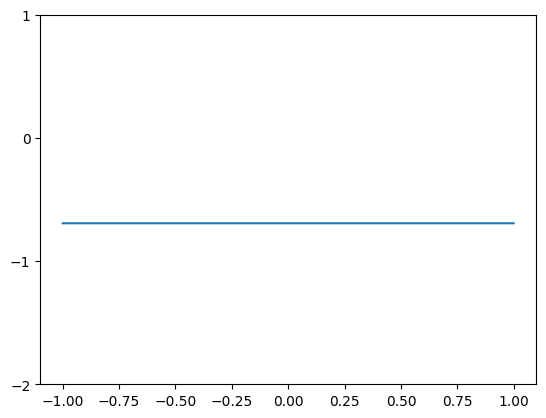

In [80]:
log_scale = -0.8
inv_scale = np.exp(-log_scale + 2.0)
n_classes = 2
bin_width = 2.0 / (num_classes - 1)
def f(x):
    # f = lambda x : np.log(1/(1 + np.exp(- inv_scale * (x  + 0.5 * bin_width))) - 1/(1 + np.exp(- inv_scale* (x  - 0.5 * bin_width))))
    # a = 1/(1 + np.exp(- inv_scale * (x  + 0.5 * bin_width)))
    # b = 1/(1 + np.exp(- inv_scale* (x  - 0.5 * bin_width)))
    # return np.log(a - b)
    log_cdf_min = -torch.log1p((-inv_scale * (x - 0.5 * bin_width)).exp())
    log_cdf_plus = -torch.log1p((-inv_scale * (x + 0.5 * bin_width)).exp())
    return log_cdf_plus + torch.log1p(-torch.exp(log_cdf_min - log_cdf_plus) + 1e-6)

import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-1, 1, n_classes)
y = f(torch.from_numpy(x)).numpy()
plt.plot(x, y)
plt.yticks(np.arange(-n_classes, n_classes, 1))
plt.show()

In [72]:
import torch.nn.functional as F

In [91]:
# Example of target with class indices
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)

In [92]:
target

tensor([4, 2, 2])

In [93]:
input

tensor([[-1.3242, -0.5223, -0.1654,  1.0347, -2.5637],
        [ 0.7290,  0.1215, -1.1901,  1.7299, -1.8947],
        [ 0.9084,  0.1120,  0.0902, -0.9613, -0.3364]], requires_grad=True)

In [17]:
log_scale

tensor([[[[-0.5189]]]])

In [83]:
a = torch.rand(5)
b = torch.rand(4, 6, 1)

In [87]:
a - b

tensor([[[-0.2368, -0.1274,  0.2704,  0.4074,  0.4190],
         [-0.6242, -0.5147, -0.1169,  0.0200,  0.0316],
         [-0.3406, -0.2311,  0.1667,  0.3036,  0.3152],
         [-0.2939, -0.1845,  0.2133,  0.3503,  0.3619],
         [-0.6538, -0.5443, -0.1465, -0.0096,  0.0020],
         [-0.1861, -0.0767,  0.3211,  0.4581,  0.4697]],

        [[-0.5814, -0.4720, -0.0742,  0.0628,  0.0744],
         [-0.3413, -0.2319,  0.1659,  0.3029,  0.3145],
         [-0.2290, -0.1196,  0.2782,  0.4152,  0.4268],
         [-0.2854, -0.1759,  0.2219,  0.3588,  0.3704],
         [-0.1633, -0.0539,  0.3439,  0.4809,  0.4925],
         [-0.3065, -0.1970,  0.2008,  0.3377,  0.3493]],

        [[-0.5535, -0.4441, -0.0463,  0.0907,  0.1023],
         [-0.6832, -0.5738, -0.1760, -0.0390, -0.0274],
         [ 0.0037,  0.1131,  0.5109,  0.6479,  0.6595],
         [ 0.0723,  0.1818,  0.5796,  0.7165,  0.7281],
         [-0.2490, -0.1395,  0.2583,  0.3953,  0.4069],
         [-0.5142, -0.4047, -0.0069,  0.1300

In [86]:
a.unsqueeze(dim=0).unsqueeze(dim=0) - b

tensor([[[-0.2368, -0.1274,  0.2704,  0.4074,  0.4190],
         [-0.6242, -0.5147, -0.1169,  0.0200,  0.0316],
         [-0.3406, -0.2311,  0.1667,  0.3036,  0.3152],
         [-0.2939, -0.1845,  0.2133,  0.3503,  0.3619],
         [-0.6538, -0.5443, -0.1465, -0.0096,  0.0020],
         [-0.1861, -0.0767,  0.3211,  0.4581,  0.4697]],

        [[-0.5814, -0.4720, -0.0742,  0.0628,  0.0744],
         [-0.3413, -0.2319,  0.1659,  0.3029,  0.3145],
         [-0.2290, -0.1196,  0.2782,  0.4152,  0.4268],
         [-0.2854, -0.1759,  0.2219,  0.3588,  0.3704],
         [-0.1633, -0.0539,  0.3439,  0.4809,  0.4925],
         [-0.3065, -0.1970,  0.2008,  0.3377,  0.3493]],

        [[-0.5535, -0.4441, -0.0463,  0.0907,  0.1023],
         [-0.6832, -0.5738, -0.1760, -0.0390, -0.0274],
         [ 0.0037,  0.1131,  0.5109,  0.6479,  0.6595],
         [ 0.0723,  0.1818,  0.5796,  0.7165,  0.7281],
         [-0.2490, -0.1395,  0.2583,  0.3953,  0.4069],
         [-0.5142, -0.4047, -0.0069,  0.1300

In [89]:
b.ndim

3

In [42]:
torch.arange(5 + 1, dtype=torch.float64) / 5

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000], dtype=torch.float64)

In [ ]:
# sampled_adata_test = sampled_adata_test.T
sampled_adata_test.layers['x_raw'] = sampled_adata_test.X.copy()
sampled_adata_test = pseudo_bulk(sampled_adata_test,
            genes=list(sampled_adata_test.obs['ens_id']),
            cell_type_col='cell types',
            gene_col='ens_id',
            mode='mean',
            expr_threshold=0,
            mem_efficient_mode=True,
            layer='x_raw')